In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [3]:
def new_parameters():
    inertias = np.array([7.94e-4,
                         3.79e-6,
                         3.00e-6,
                         2.00e-6,
                         7.81e-3,
                         2.00e-6,
                         (3.17e-6 - 7800*(np.pi*(0.006**4)/32)*0.342/6) + 7800*(np.pi*(0.008**4)/32)*0.342/6,
                         5.01e-5,
                         6.50e-6,
                         5.65e-5,
                         4.27e-6,
                         3.25e-4,
                         1.20e-4,
                         1.15e-5,
                         1.32e-4,
                         4.27e-6,
                         2.69e-4,
                         1.80e-4,
                         2.00e-5,
                         2.00e-4,
                         4.27e-6,
                         4.95e-2])

    stiffnesses = np.array([1.90e5,
                            6.95e3,
                            90.00,
                            90.00,
                            90.00,
                            90.00,
                            80e9*(np.pi*(0.008**4)/32)/0.342,
                            4.19e4,
                            5.40e3,
                            4.19e4,
                            1.22e3,
                            4.33e4,
                            3.10e4,
                            1.14e3,
                            3.10e4,
                            1.22e4,
                            4.43e4,
                            1.38e5,
                            2.00e4,
                            1.38e5,
                            1.22e4])

    damping = np.array([8.08,
                        0.29,
                        0.24,
                        0.24,
                        0.24,
                        0.24,
                        0.00,
                        1.78,
                        0.23,
                        1.78,
                        0.52,
                        1.84,
                        1.32,
                        0.05,
                        1.32,
                        0.52,
                        1.88,
                        5.86,
                        0.85,
                        5.86,
                        0.52])


    external_damping = np.array([0.0030,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0042,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.0042,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0.2400])

    gear_ratios = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1/3, 1, 1, 1, 1, 1/4, 1, 1, 1, 1])

    return inertias, stiffnesses, damping, external_damping, gear_ratios

In [4]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios, full_B=False, gear_B=False):
    """
    Parameters:
    
    inertia : list
        The inertia values of each lumped mass in order from index 1...n
    stiff : list
        The stiffness values between each lumped mass in order from index 1...n
    damp : list
        The viscous damping values between each lumped mass in order from index 1...n
    damp_ext : list
        The external damping corresponding to torque losses from the motors and gears
    ratios : list
        The gear ratios between each lumped mass
    full_B : bool
        If true, the input matrix B is shape n x p, allowing applying an input at the
        location of every lumped mass. By default it's shape is n x 2, for applying an input
        at the locations corresponding to the driving motor and the propeller. 
        
    Returns:
    
    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    D : numpy.ndarray
        The feedthrough matrix, always a zero matrix

    """
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)

    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)

    ks = -np.hstack((stiff*ratios, 0))
    A12 = np.delete(
        (np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1
    )


    A23 = np.delete(
        np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0
    )

    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))

    if full_B:
        B = np.zeros(A.shape)
        for i in range(len(inertia)):
            B[i,i] += 1/inertia[i]
    elif gear_B:
        B = np.zeros((A.shape[0], 2))
        B[0,0] += 1/inertia[0]
        B[11,1] -= 1/inertia[11]
    else:
        B = np.zeros((A.shape[0], 2))
        B[0,0] += 1/inertia[0]
        B[len(inertia)-1, 1] -= 1/inertia[-1]

    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))

    return A, B, C, D

In [5]:
def c2d(A, B, ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time ts.
    The function returns matrices Ad, Bd of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]

    return Ad, Bd

In [6]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))

    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O


def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)

    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B,
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z

        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))

        # then add the impulse responses
        A_power2 = np.copy(A)

        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))

        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))

        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1

    return gamma


def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)

    # delete incomplete rows
    D2 = D2[:-2*m, :]

    return D2

In [7]:
# parameters for simulated excitations
fs = 1000  # sampling frequency
t_sim = np.arange(0,10,1/fs)  # timesteps
dt_sim = np.mean(np.diff(t_sim))  # timestep length

In [8]:
def impulse_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_imp : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """
    U_imp = np.zeros((len(sim_times), 2))

    e1 = np.random.normal(0, .1, U_imp.shape[0])
    e2 = np.random.normal(0, .1, U_imp.shape[0])

    one_hit = np.hstack((np.linspace(0, 0.34, 7), np.linspace(0.38, 0.64, 7), np.linspace(0.67, 0.87, 7), np.linspace(0.9, 0.98, 7)))

    U_imp[:,0] += 2.7 + e1
    U_imp[:,1] += e2
    U_imp[3200:3228,1] += one_hit*10
    U_imp[3228:3228+28,1] += np.flip(one_hit*10)
    U_imp[5200:5228,1] += one_hit*10
    U_imp[5228:5228+28,1] += np.flip(one_hit*10)
    U_imp[8200:8228,1] += one_hit*10
    U_imp[8228:8228+28,1] += np.flip(one_hit*10)

    if plot:
        plt.subplot(211)
        plt.plot(sim_times, U_imp[:,0], label='Driving motor setpoint', color='blue')
        plt.ylabel('Torque (Nm)')
        plt.legend()

        plt.subplot(212)
        plt.plot(sim_times, U_imp[:,1], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_imp

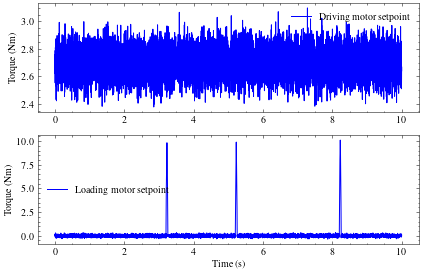

In [9]:
impulse_sim = impulse_excitation(t_sim, plot=True)

In [10]:
def get_testbench_state_space(dt, full_B=False, gear_B=False):
    """
    This function returns the discrete-time state-space matrices of the testbench model.
    """
    inertias, stiffs, damps, damps_ext, ratios = new_parameters()
    Ac, Bc, C, D = state_space_matrices(inertias, stiffs, damps, damps_ext, ratios, full_B=full_B, gear_B=gear_B)

    A, B = c2d(Ac, Bc, dt)

    return A, B, C, D

In [11]:
dt = np.mean(np.diff(t_sim))
A, B, C, D = get_testbench_state_space(dt)
ss = (A, B, C, D)

In [12]:
# include second torque transducer to the observation matrix
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4
D_mod = np.zeros((C_mod.shape[0], B.shape[1]))

In [13]:
def progressbar(it, prefix="", size=60, out=sys.stdout, show_print=False):
    """
    A function used to display a progress bar in the console.
    """
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count}", end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    if show_print:
        print("\n", flush=True, file=out)

In [14]:
def get_data_equation_matrices(A, B, C, D, n, bs):
    D2 = second_difference_matrix(bs, B.shape[1])
    O_mat = O(A, C, bs)
    G = gamma(A, B, C, bs)
    L = np.eye(bs*B.shape[1])

    return O_mat, G, D2, L

# Regularized WLS for estimating unknown input and initial state

We can formulate the estimation of unknown input torque and initial state as

\begin{equation}
      \begin{aligned}
      \underset{u,v}{\text{minimize}}\quad& L(u) + v^\top W_{\mathrm{R}} v \\
      \text{subject to} \quad& v = y - H\varphi,
    \end{aligned}
\end{equation}

where $H = \left[ \mathcal{O} \text{ } \Gamma \right] $, $\varphi = \left[ x(0)^\top u(k)^\top \right]^\top $, $W_{\mathrm{R}} = I_{N} \otimes R^{-1}$ and $L(u)$ is a regularization function.

We can assume the input varies smoothly, for input torques $u_{\mathrm{m}}$ from the motor and $u_{\mathrm{p}}$ from the propeller, the regularization term is

$\begin{equation}
        \Delta_2 u = 
        \begin{bmatrix}
            1 & 0 & -2 & 0 & 1 & & \\
              & 1 & 0 & -2 & 0 & 1 &\\
              &  &\ddots &\ddots &\ddots &\ddots & \\
              &  & 1 & 0 & -2 & 0 & 1 & \\
              &  & & 1 & 0 & -2 & 0 & 1
        \end{bmatrix}        
        \begin{bmatrix}
            u_{\mathrm{m}}(0) \\
            u_{\mathrm{p}}(0) \\
            \vdots \\
            u_{\mathrm{m}}(k) \\
            u_{\mathrm{p}}(k)
        \end{bmatrix}.
\end{equation}$

For rotating mechanical systems it is feasible to assume that the states of coupled elements, e.g., the rotating speed of two adjacent lumped masses, do not differ considerably from each other. Thus, a regularization term for the unknown initial state $x(0)$ can be defined in a similar fashion as for the input, by constraining the first difference of the state variables of $x(0)$.

$\begin{equation}
        \Delta_1 x(0) = 
        \begin{bmatrix}
            1 & -1 & & & & & \\
              & 1 & -1 & & & & \\
              & & \ddots & \ddots & & \\
              & & & 1 & -1 & & \\
              & & & & 1 & -1 & \\
              & & & & & \ddots & \ddots
         \end{bmatrix}
         \begin{bmatrix}
             \dot{\theta}_1(0) \\
             \dot{\theta}_2(0) \\
             \vdots \\
             \tau_{\mathrm{m}}(0) \\
             \tau_2(0) \\
             \vdots
        \end{bmatrix}.
\end{equation}$

It should be noted that there are zero rows in $\Delta_1$ where the aforementioned assumption does not hold, i.e., at gear locations and where the physical state quantities are different to ensure, for example, that speed is not subtracted from torque.

The regularization function can then be formulated as

$\begin{equation}
    L(u) = \biggl\| \begin{bmatrix}\lambda_1 \Delta_1 & 0 \\ 0 & \lambda_2 \Delta_2\end{bmatrix} \begin{bmatrix}x(0) \\ u\end{bmatrix} \biggl\|^2_2 = \| \Delta(\lambda_1, \lambda_2) \varphi \|^2_2,
\end{equation}$

where $\lambda_1$ and $\lambda_2$ are scalars which can be used to scale how strongly the regularization is enforced.

The regularized WLS problem has an analytical solution
\begin{equation}
    \hat{\varphi} = \left( \Delta(\lambda_1,\lambda_2)^{\top} \Delta(\lambda_1,\lambda_2) + H^\top W_\mathrm{R} H \right)^{-1}H^\top W_\mathrm{R} y,
    \label{eq:optimization2_analytic}
\end{equation}
where $\hat{\varphi}$ is an estimate of the initial state and input torques.

In [15]:
def ell2_analytical(ss, measurements, batch_size, overlap, times, lam=0.1, use_trend_filter=False, print_bar=True):
    """
    Analytical solution of the l2 regularized LS problem.
    Minimizes the sum of squared residuals, including an l2 constraint.
    """
    dt = np.mean(np.diff(times))
    n = len(times)
    bs = batch_size + 2*overlap
    loop_len = int(n/batch_size)

    A, B, C, D = ss  # state space model
    O_mat, G, D2, L = get_data_equation_matrices(A, B, C, D, n, bs)  # data equation matrices

    if use_trend_filter:
        regul_matrix = D2 # regularization matrix
    else:
        regul_matrix = L

    H = np.hstack([O_mat, G])  # extended observation and impulse response matrix
    
    # initial state regularization, Z: no regularization, I: yes regularization
    Z = np.zeros((regul_matrix.shape[0], O_mat.shape[1]))
    S = (np.eye(O_mat.shape[1])-np.eye(O_mat.shape[1], k=1))
    S[11] *= 0
    S[16] *= 0
    S[21] *= 0
    S[22+11] *= 0
    S[22+16] *= 0
    I = np.vstack([
        0.1*S,
        np.zeros((regul_matrix.shape[0]-O_mat.shape[1], O_mat.shape[1]))
    ])
    M = np.vstack(
        [np.hstack([I, np.zeros_like(regul_matrix)]), np.hstack([Z, regul_matrix])]
    )  # extended regularization matrix
    
    LS = LA.inv(H.T @ H + lam*(M.T @ M)) @ H.T
    
    input_estimates = []

    for i in progressbar(range(loop_len), "Calculating estimates: ", loop_len, show_print=print_bar):
        if i == 0:
            batch = measurements[:bs,:]
        #elif i == loop_len-1:
            #batch = np.zeros((bs, measurements.shape[1]))
            # zero padding to finish estimation loop correctly
        else:
            batch = measurements[i*batch_size-overlap:(i+1)*batch_size+overlap,:]

        y = batch.reshape(-1,1)

        estimate = LS @ y

        input_estimates.append(estimate)

    return input_estimates

# Simulated impulse excitation test

(1500, 43)


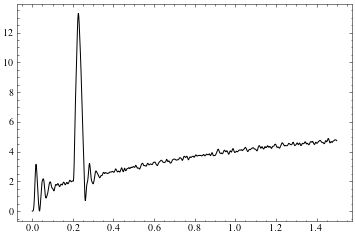

In [16]:
t_sim_short = t_sim[:1500]
excitation_sim = impulse_sim[3000:4500]
tout_sim_imp, yout_sim_imp, xout_sim_imp = dlsim((A, B, C_mod, D_mod, 1e-3), excitation_sim, t=t_sim_short)
print(xout_sim_imp.shape)

plt.plot(tout_sim_imp, yout_sim_imp[:,-1])

In [17]:
# HP IMPULSE
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
lam_imp = 1
batch_size = 500
measurements_sim_imp = yout_sim_imp[:,:-1] + np.random.normal(0, .1, yout_sim_imp[:,:-1].shape)
estimates_imp_sim = ell2_analytical(
    ss, measurements_sim_imp, batch_size, 0, t_sim_short, lam=lam_imp, use_trend_filter=True
)

Calculating estimates: [███] 3/3



In [18]:
motor_estimates_imp_sim = np.vstack((estimates_imp_sim[0][43::2], estimates_imp_sim[1][43::2], estimates_imp_sim[2][43::2]))
propeller_estimates_imp_sim = np.vstack((estimates_imp_sim[0][44::2], estimates_imp_sim[1][44::2], estimates_imp_sim[2][44::2]))
initial_state_estimate = estimates_imp_sim[1][:43]
initial_speeds = initial_state_estimate[:22]
initial_torques = initial_state_estimate[22:]

U_est_imp_sim = np.hstack((motor_estimates_imp_sim, propeller_estimates_imp_sim))
tout_imp_sim, yout_imp_sim, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp_sim, t=t_sim_short)

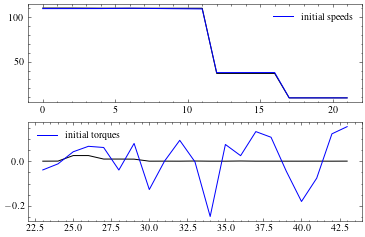

In [19]:
plt.subplot(211)
plt.plot(np.arange(0, 22, 1), xout_sim_imp[500,:][:22])
plt.plot(np.arange(0, 22, 1), initial_speeds, 'b-', label='initial speeds')
plt.legend()
plt.subplot(212)
plt.plot(np.arange(23, 44, 1), xout_sim_imp[500,:][22:])
plt.plot(np.arange(23, 44, 1), initial_torques, 'b-', label='initial torques')
plt.legend()

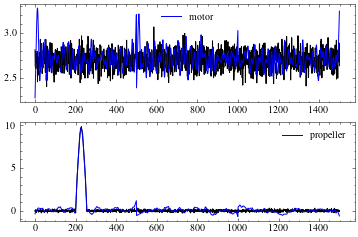

In [20]:
plt.subplot(211)
plt.plot(excitation_sim[:,0])
plt.plot(motor_estimates_imp_sim, 'b-', label='motor')
plt.legend()
plt.subplot(212)
plt.plot(excitation_sim[:,1])
plt.plot(propeller_estimates_imp_sim, 'b-', label='propeller')
plt.legend()

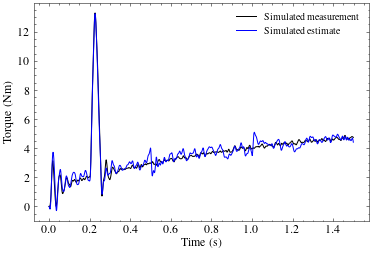

In [21]:
plt.plot(t_sim_short, yout_sim_imp[:,-1], label="Simulated measurement")
plt.plot(tout_imp_sim, yout_imp_sim[:,-1], '-', c='b', label="Simulated estimate")
#plt.plot(tout_imp_sim_cov, yout_imp_sim_cov[:,-1], '-', c='b', label="HP with R")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Torque (Nm)", fontsize=12)
plt.legend()

# Testbench impulse excitation test

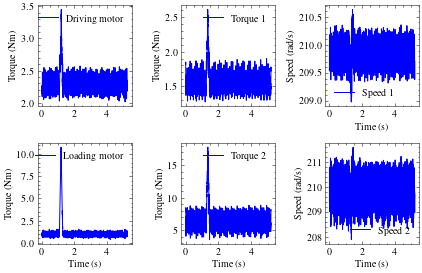

In [22]:
# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_imp = np.loadtxt("../data/masters_data/processed_data/impulse_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_imp = np.loadtxt("../data/masters_data/processed_data/impulse_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_imp[:,0], sensor_data_imp[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
def process_estimates(n_batches, overlap, estimates, nstates=43):
    """
    Here the input and initial state estimates are processed.
    Overlapped sections are discarded and the input estimate batches are stacked one after the other.
    """
    motor_estimates, propeller_estimates = [], []
    motor_est_overlap, prop_est_overlap = [], []
    for i in range(n_batches):
        if i == 0:
            all_motor_estimates = estimates[i][nstates::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = all_motor_estimates[:-2*overlap]
            all_propeller_estimates = estimates[i][(nstates+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = all_propeller_estimates[:-2*overlap]
        else:
            all_motor_estimates = estimates[i][nstates::2]
            motor_est_overlap.append(all_motor_estimates)
            motor_estimates = np.concatenate(
                (motor_estimates, all_motor_estimates[overlap:-overlap])
            )
            all_propeller_estimates = estimates[i][(nstates+1)::2]
            prop_est_overlap.append(all_propeller_estimates)
            propeller_estimates = np.concatenate(
                (propeller_estimates, all_propeller_estimates[overlap:-overlap])
            )
    
    return motor_estimates, propeller_estimates

In [24]:
# IMPULSE
# measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
measurements_imp = sensor_data_imp[:,1:]
time_imp = sensor_data_imp[:measurements_imp.shape[0],0]
lam_imp = 1
estimates_imp = ell2_analytical(
    ss, measurements_imp[:,:3], batch_size, 0, time_imp, lam=lam_imp, use_trend_filter=True
)

Calculating estimates: [██████████] 10/10



In [25]:
motor_estimates_imp, propeller_estimates_imp = process_estimates(len(estimates_imp), 1, estimates_imp)

In [26]:
# Excitation matrix using estimated input torques
U_est_imp = np.hstack((motor_estimates_imp, propeller_estimates_imp))

In [27]:
# The testbench is simulated using the estimated input torques, with zero initial state.
print(U_est_imp.shape)
print(time_imp.shape)
tout_imp, yout_imp, _ = dlsim((A, B, C_mod, D_mod, dt), U_est_imp, t=time_imp[:-234-20])

(4980, 2)
(5234,)


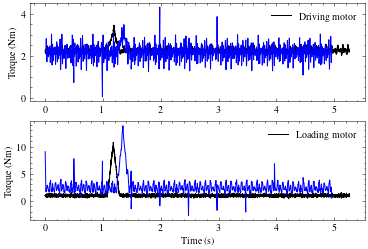

In [28]:
plt.subplot(211)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,2], label='Driving motor', color='black')
plt.plot(time_imp[:-254], motor_estimates_imp, 'b-')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(212)
plt.plot(motor_data_imp[:,0], motor_data_imp[:,4], label='Loading motor', color='black')
plt.plot(time_imp[:-254], propeller_estimates_imp, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

## Motor measurements not in sync

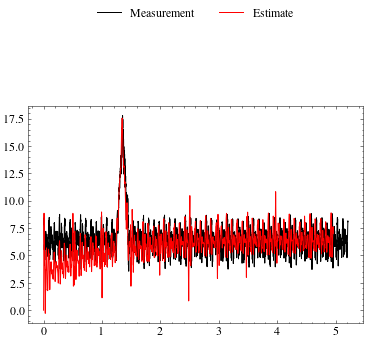

In [29]:
plt.plot(time_imp, measurements_imp[:,-1], c='black', label="Measurement")
plt.plot(tout_imp, yout_imp[:,-1], '-', c='r', label="Estimate")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=False, fontsize=12
)
#plt.xlim(1.,1.9)
#plt.ylim(2,22)